# Arboles de clasificación
Para la clasificación se toman en cuenta las siguientes medidas para evaluar cada division, similar al _RSS_

1. Tasa de error de clasificación (Classification error rate)

$$CER=1-max(\hat{p}_{jk})$$
Donde $\hat{p}_{jk}$ es la proporción de observaciones de la clase j en el nodo k.

2. Indice de Gini

$$GI=\sum_{j=1}^J \hat{p}_{jk} (1- \hat{p}_{jk}) $$

3. Chi cuadrado

$$\chi^2=\sum_{j=1}^J \frac{(Observado_j-Esperado_j)^2}{Esperado_j}$$

4. Entropia cruzada (Cross Entropy)

$$D=-\sum_{j=1}^J \hat{p}_{jk} \ln(\hat{p}_{jk})$$


El proceso de construcción se hace en los siguientes pasos:

1. Para cada división se calcula la medida predefinida

2. Se calcula el valor

$$\frac{n_A\times m_A + n_B \times m_B}{n}$$

3. Se selecciona la divisón que tenga el mejor valor de la medida del paso 2

4. Al finalizar la construcción del arbol se calcula la deviance total como

$$Deviance=-2\sum_{j=1}^J \sum_{k=1}^K n_{jk}\ln (\hat{p}_{jk})$$
y la _residual mean deviance_ como $Deviance/(n-K)$



In [1]:
import pandas as pd
import numpy as np
import plotly.express as px
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.feature_selection import RFE
from sklearn.model_selection import train_test_split
from sklearn import linear_model, tree
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, classification_report
from sklearn.model_selection import GridSearchCV


In [2]:
url="https://raw.githubusercontent.com/Cruzalirio/Ucentral/master/Bases/Cancer.csv"
cancer=pd.read_csv(url, sep=";", index_col=0)
Y=cancer["Tipo"]
X=cancer.drop("Tipo", axis=1)
X_train, X_test, y_train, y_test=train_test_split(X, Y, test_size=0.2)
X_train.shape

(455, 30)

# Arbol de clasificación

[Acá](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html)

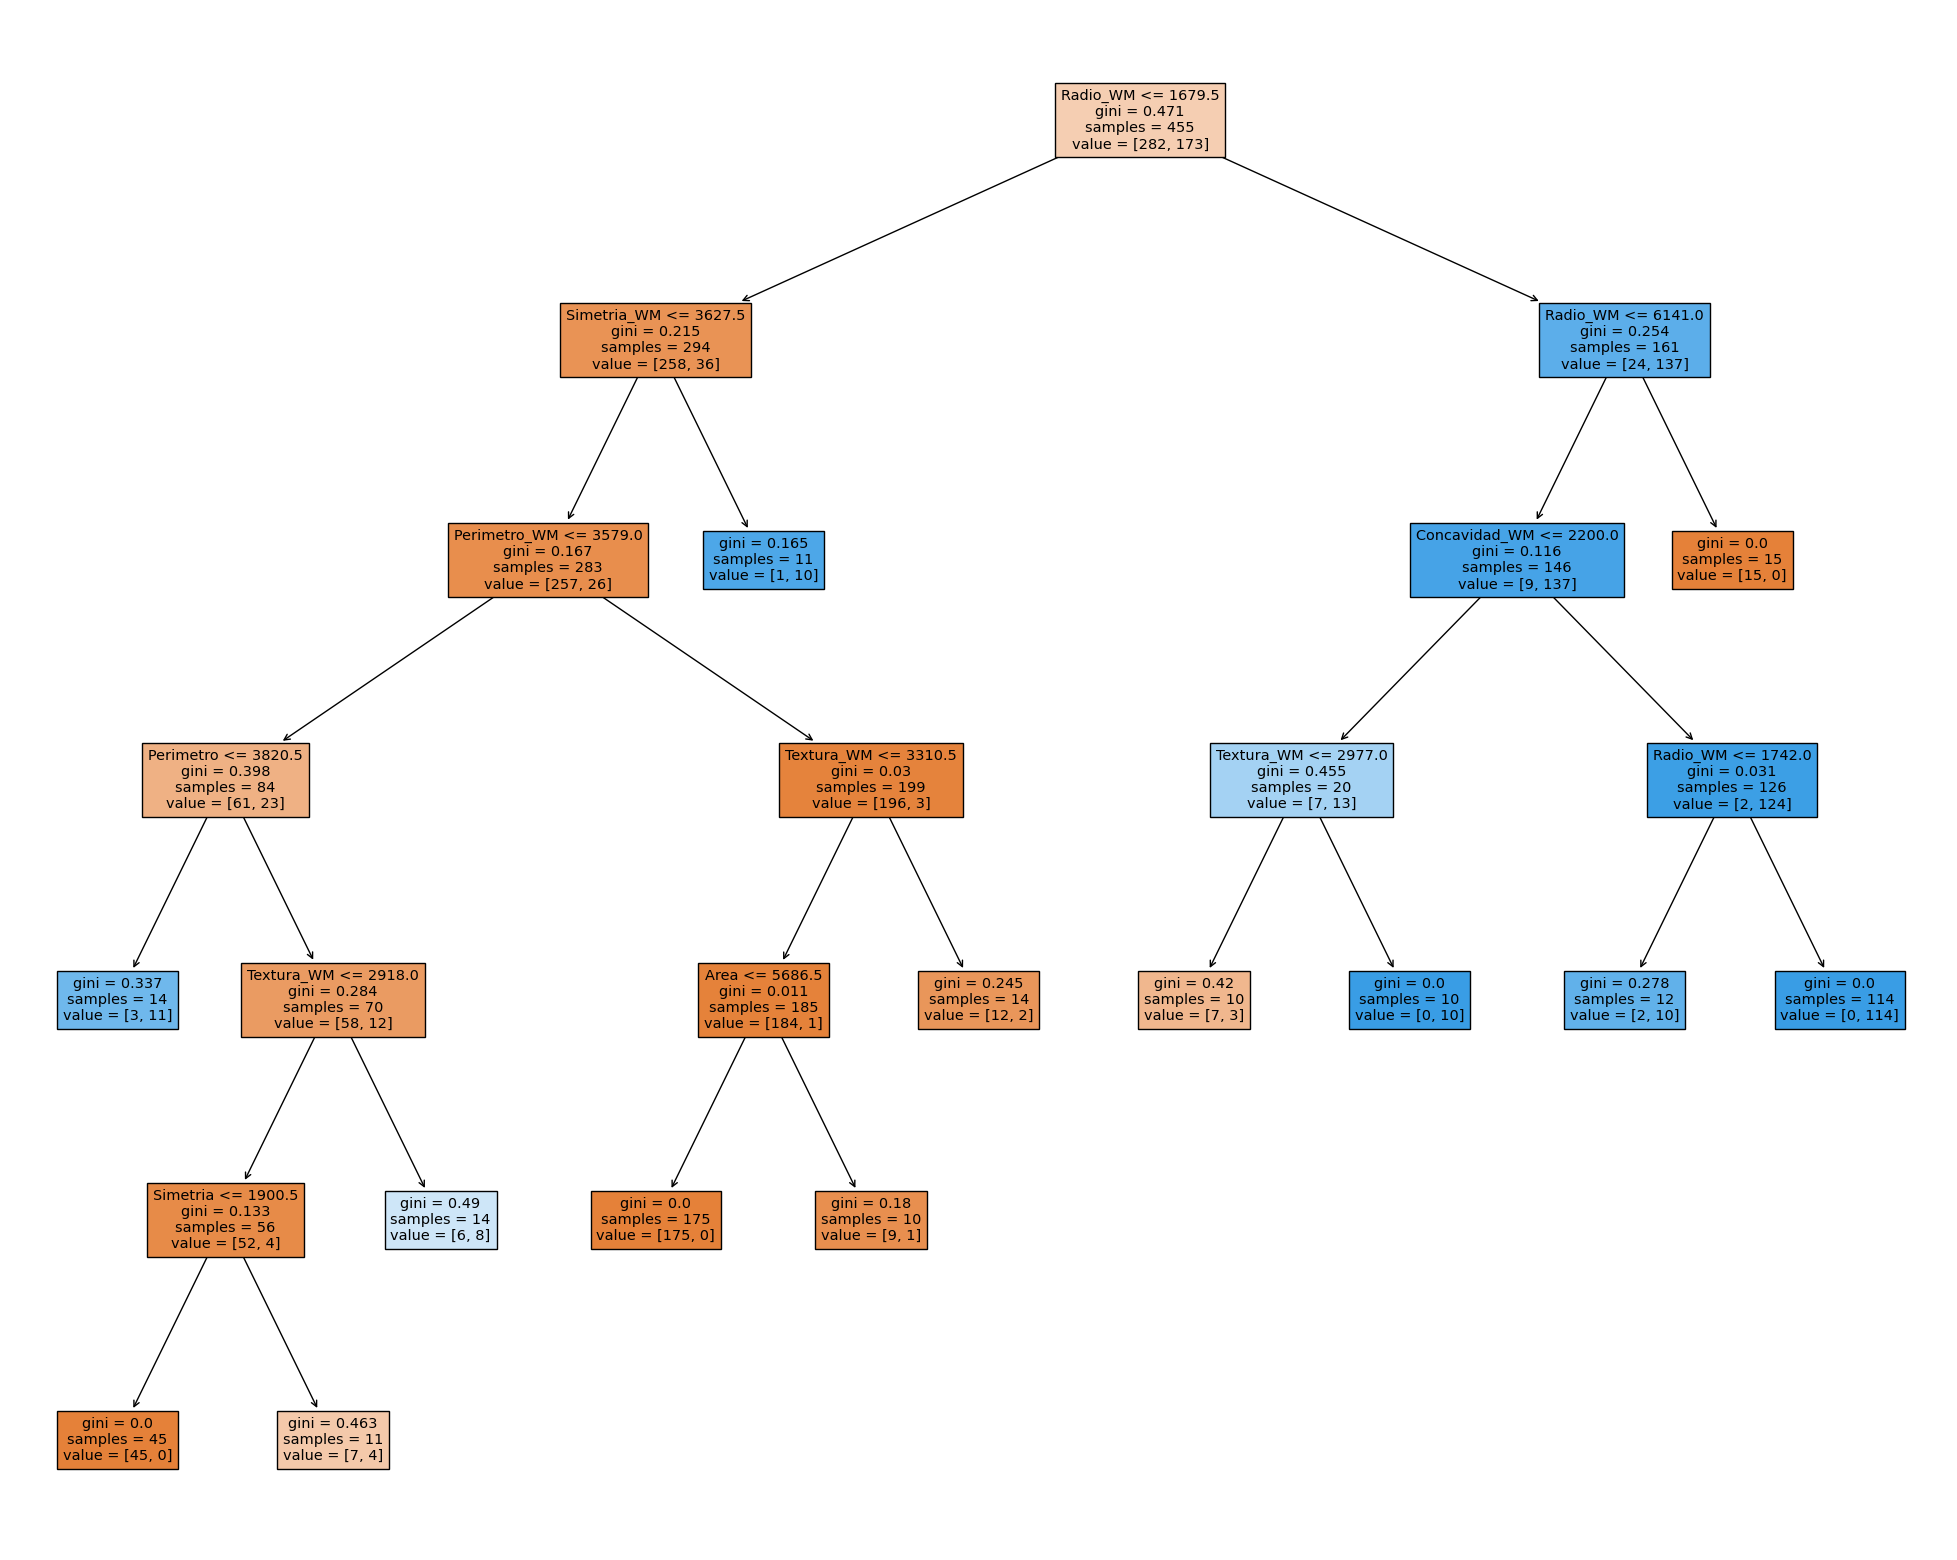

In [3]:
## Construcción del arbol
arbol=tree.DecisionTreeClassifier(criterion="gini", min_samples_split=20, min_samples_leaf=10)
arbol.fit(X_train, y_train)
fig = plt.figure(figsize=(25,20))
_ = tree.plot_tree(arbol, feature_names=X_train.columns, filled=True)

# Matriz de confusión

In [4]:
y_pred=arbol.predict(X_test)
confusion_matrix(y_test, y_pred)

array([[68,  7],
       [ 4, 35]], dtype=int64)

# Metricas de evaluación de un árbol

Las métricas estan [acá](https://scikit-learn.org/stable/modules/model_evaluation.html) 

1. Accuracy 
$$Acc=\frac{VP+VN}{n}$$

2. Balanced Accuracy

$$BAcc=\frac{1}{2}\left(\frac{VP}{VP+FN}+\frac{VN}{VN+FP} \right)$$

3. Precision
$$Prec=\frac{VP}{VP+FP}$$

4. Recall
$$Recall=\frac{VP}{VP+FN}$$

5. F1-score

$$F_1=\frac{2 (precision \times recall) }{precision + recall}$$

6. F-score

$$F_\beta=(1+\beta^2)\frac{(precision \times recall) }{\beta^2 precision + recall}$$

$$F_\beta=\frac{(1+\beta^2)VP }{(1+\beta^2)VP+
 \beta^2 FN +FP}$$

Generalmente $\beta=2$ o $\beta=1$ [Click](https://en.wikipedia.org/wiki/F-score)

# Podando con la profundidad


In [5]:
### Validacion cruzada para obtener la profundidad optima
parameters = {'max_depth':range(2,20)} ### voy a probar desde 3 hasta 20
arbol= GridSearchCV(tree.DecisionTreeClassifier(), parameters,scoring="balanced_accuracy", n_jobs=-1) ## Metrica r2
arbol.fit(X=X_train, y=y_train)
tree_model = arbol.best_estimator_ ## El mejor modelo
print (arbol.best_score_, arbol.best_params_) 

0.888454223794781 {'max_depth': 10}


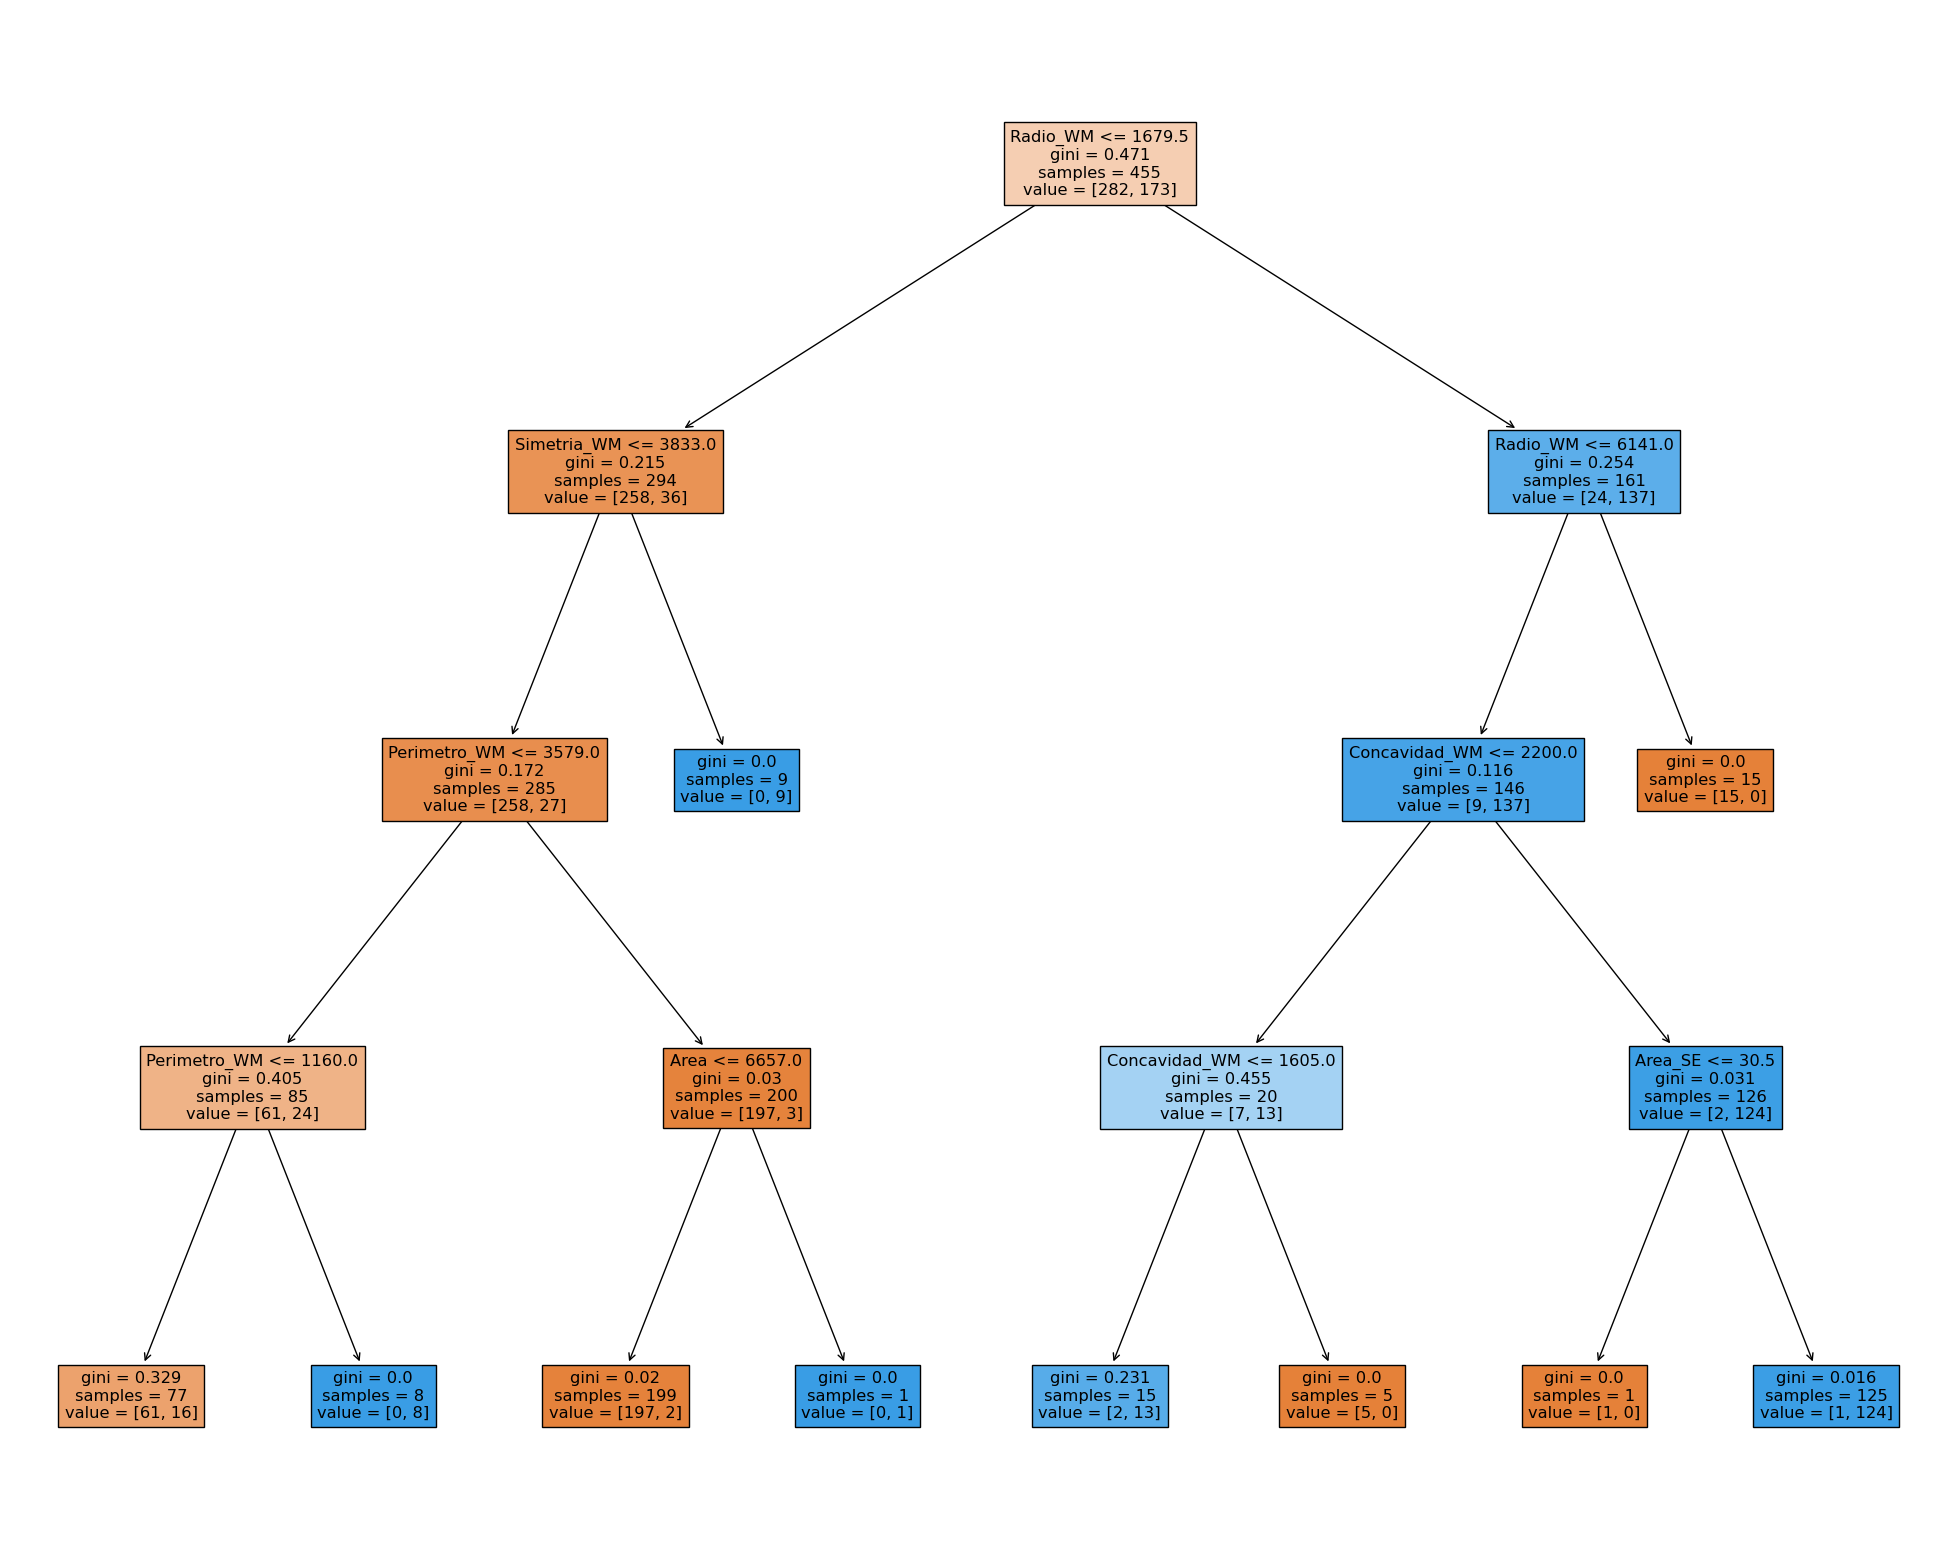

In [6]:
arbol=tree.DecisionTreeClassifier(criterion="gini", max_depth=4)
arbol.fit(X_train, y_train)
fig = plt.figure(figsize=(25,20))
_ = tree.plot_tree(arbol, feature_names=X_train.columns, filled=True)

In [7]:
y_pred=arbol.predict(X_test)
confusion_matrix(y_test, y_pred)

array([[71,  4],
       [ 6, 33]], dtype=int64)

In [8]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           B       0.92      0.95      0.93        75
           M       0.89      0.85      0.87        39

    accuracy                           0.91       114
   macro avg       0.91      0.90      0.90       114
weighted avg       0.91      0.91      0.91       114



In [9]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test, y_pred)

0.9122807017543859

In [10]:
from sklearn.metrics import recall_score
recall_score(pd.get_dummies(y_test, drop_first=True), pd.get_dummies(y_pred, drop_first=True))

0.8461538461538461

In [11]:
from sklearn.metrics import precision_score
precision_score(pd.get_dummies(y_test, drop_first=True), pd.get_dummies(y_pred, drop_first=True))

0.8918918918918919

In [12]:
from sklearn.metrics import f1_score
f1_score(pd.get_dummies(y_test, drop_first=True), pd.get_dummies(y_pred, drop_first=True))

0.868421052631579

# Podando con $\alpha$


Text(0.5, 1.0, 'Total Impurity vs effective alpha for training set')

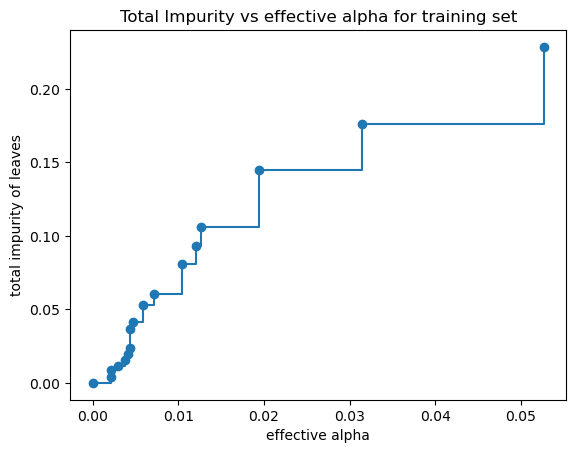

In [13]:
arbol = tree.DecisionTreeClassifier(random_state=0)
alpha= arbol.cost_complexity_pruning_path(X_train, y_train)
ccp_alphas, impurities = alpha.ccp_alphas, alpha.impurities
fig, ax = plt.subplots()
ax.plot(ccp_alphas[:-1], impurities[:-1], marker='o', drawstyle="steps-post")
ax.set_xlabel("effective alpha")
ax.set_ylabel("total impurity of leaves")
ax.set_title("Total Impurity vs effective alpha for training set")

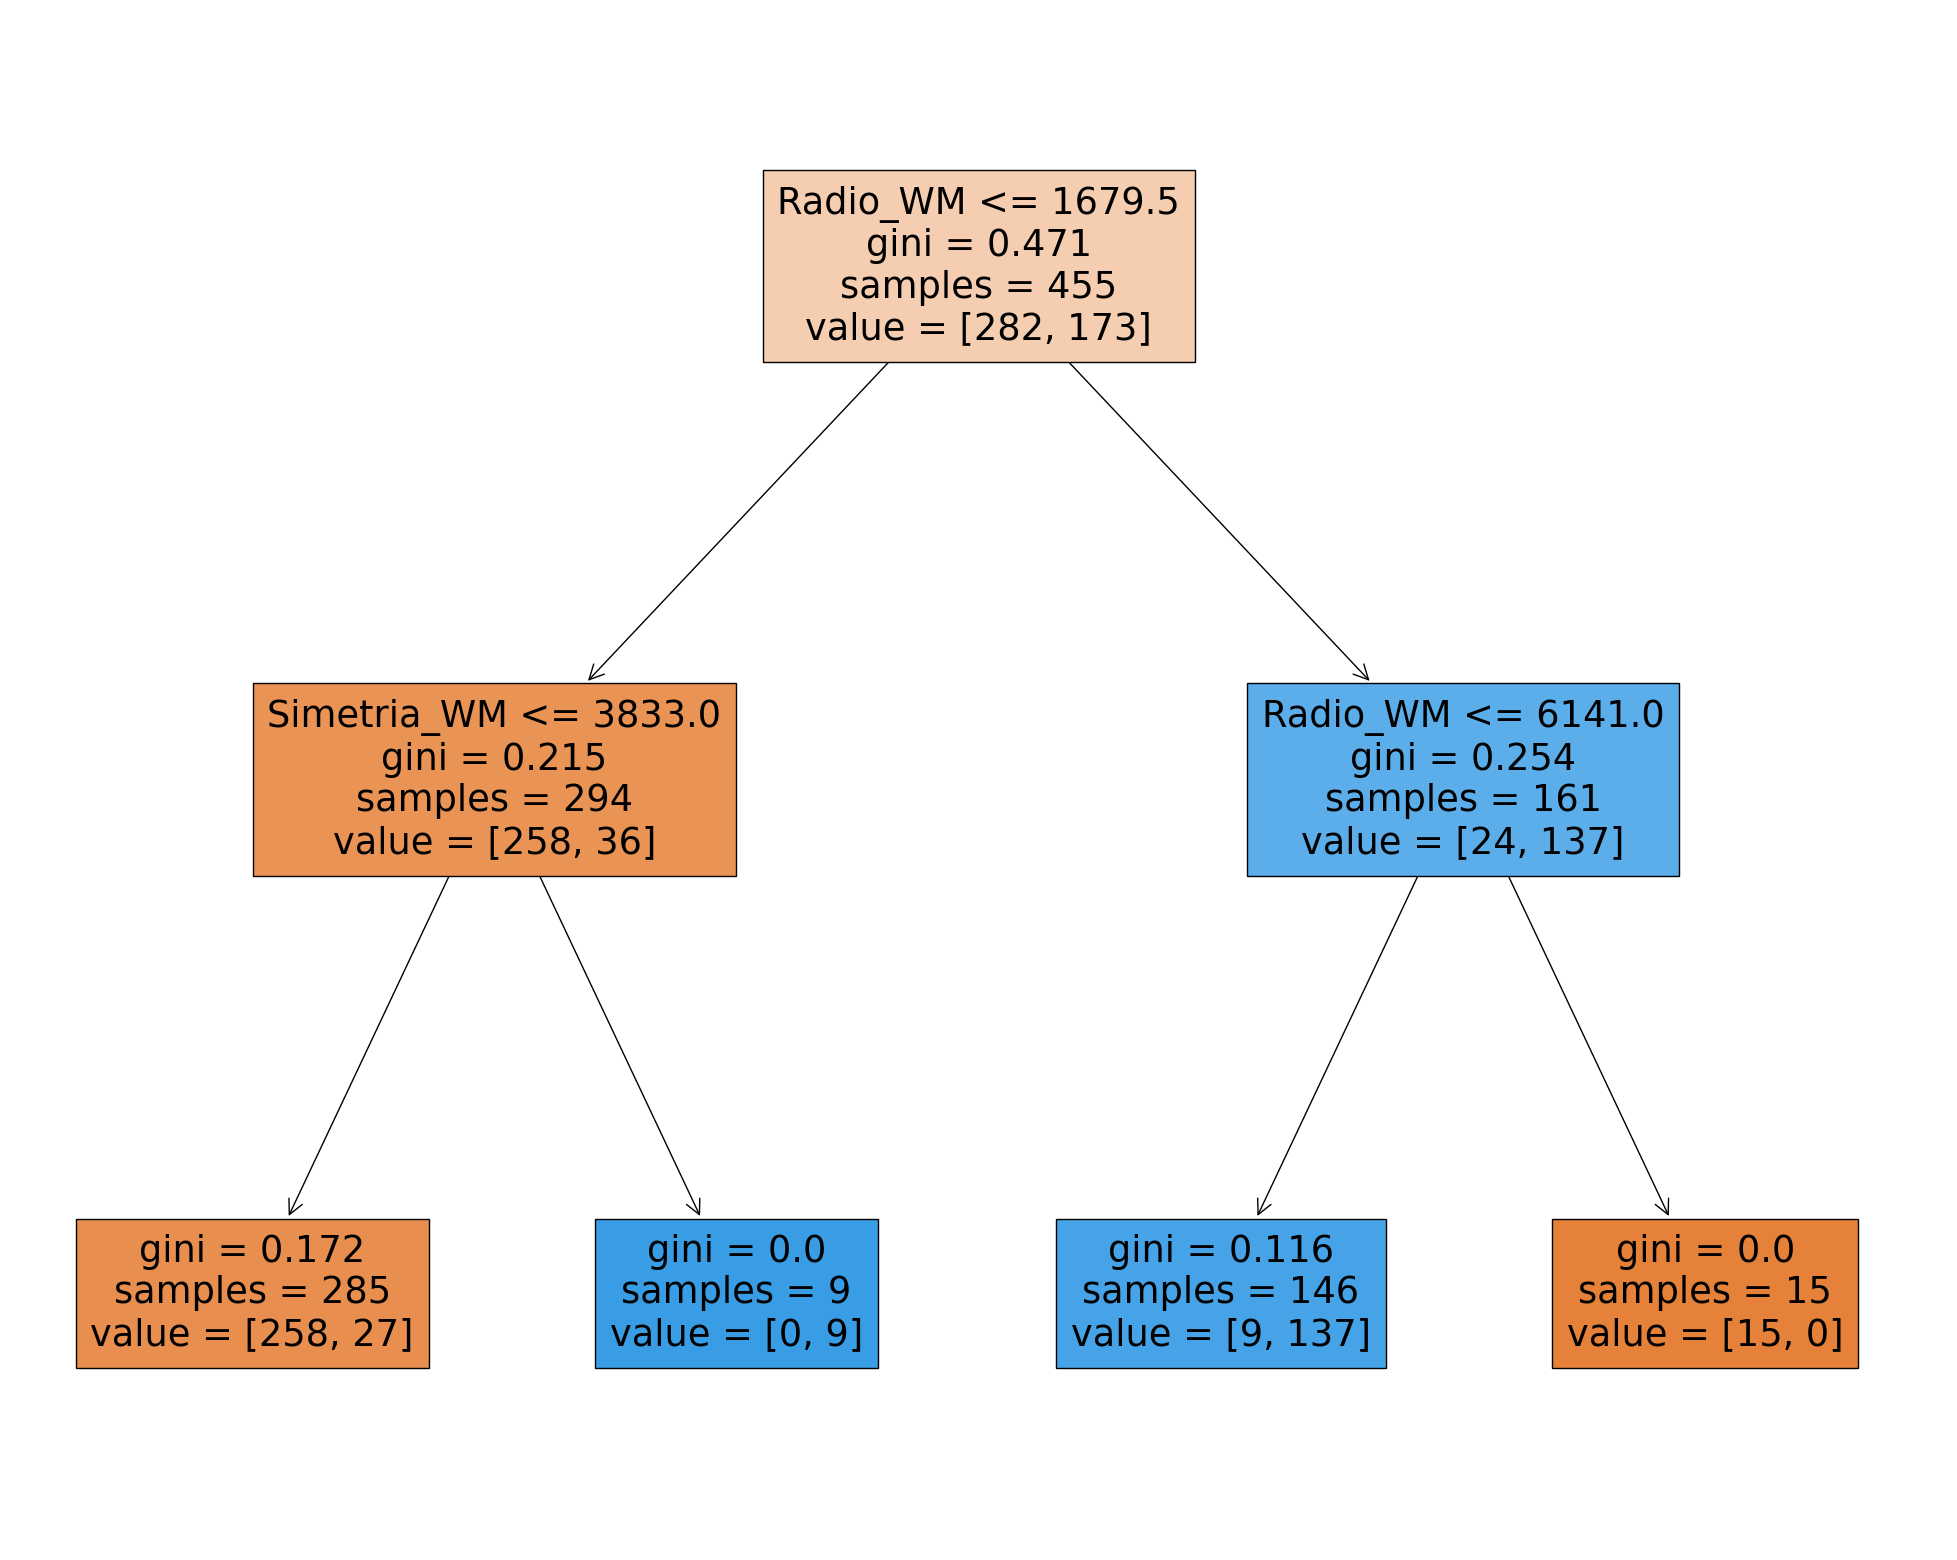

In [14]:
arbol=tree.DecisionTreeClassifier(criterion="gini",ccp_alpha=0.02)
arbol.fit(X_train, y_train)
fig = plt.figure(figsize=(25,20))
_ = tree.plot_tree(arbol, feature_names=X_train.columns, filled=True)

In [15]:
y_pred=arbol.predict(X_test)
confusion_matrix(y_test, y_pred)

array([[71,  4],
       [ 9, 30]], dtype=int64)

In [16]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           B       0.89      0.95      0.92        75
           M       0.88      0.77      0.82        39

    accuracy                           0.89       114
   macro avg       0.88      0.86      0.87       114
weighted avg       0.89      0.89      0.88       114



# Base de Spam

In [17]:
url="https://raw.githubusercontent.com/Cruzalirio/Ucentral/master/Bases/spam.csv"
email=pd.read_csv(url, sep=";", decimal=",")
email

,spam,to_multiple,from,cc,sent_email,time,image,attach,dollar,winner,...,viagra,password,num_char,line_breaks,format,re_subj,exclaim_subj,urgent_subj,exclaim_mess,number
0,0,0,1,0,0,2012-01-01 01:16:41,0,0,0,no,...,0,0,11.370,202,1,0,0,0,0,big
1,0,0,1,0,0,2012-01-01 02:03:59,0,0,0,no,...,0,0,10.504,202,1,0,0,0,1,small
2,0,0,1,0,0,2012-01-01 11:00:32,0,0,4,no,...,0,0,7.773,192,1,0,0,0,6,small
3,0,0,1,0,0,2012-01-01 04:09:49,0,0,0,no,...,0,0,13.256,255,1,0,0,0,48,small
4,0,0,1,0,0,2012-01-01 05:00:01,0,0,0,no,...,0,2,1.231,29,0,0,0,0,1,none
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3916,1,0,1,0,0,2012-03-30 19:03:45,0,0,0,no,...,0,0,0.332,12,0,0,0,0,0,small
3917,1,0,1,0,0,2012-03-31 09:13:19,0,0,1,no,...,0,0,0.323,15,0,0,0,0,0,small
3918,0,1,1,0,0,2012-03-30 11:20:33,0,0,0,no,...,0,0,8.656,208,1,0,0,0,5,small
3919,0,1,1,0,0,2012-03-28 11:00:49,0,0,0,no,...,0,0,10.185,132,0,0,0,0,0,small


In [18]:
email.groupby(["spam"]).size()

spam
0    3554
1     367
dtype: int64

In [19]:
Y=email["spam"].astype(str) ### Volver a Y cualitativa
X=email.drop(["spam", "time"], axis=1)
X=pd.get_dummies(X, drop_first=True) 
X_train, X_test, y_train, y_test=train_test_split(X, Y, test_size=0.2, stratify=Y)
X_train.shape

(3136, 20)

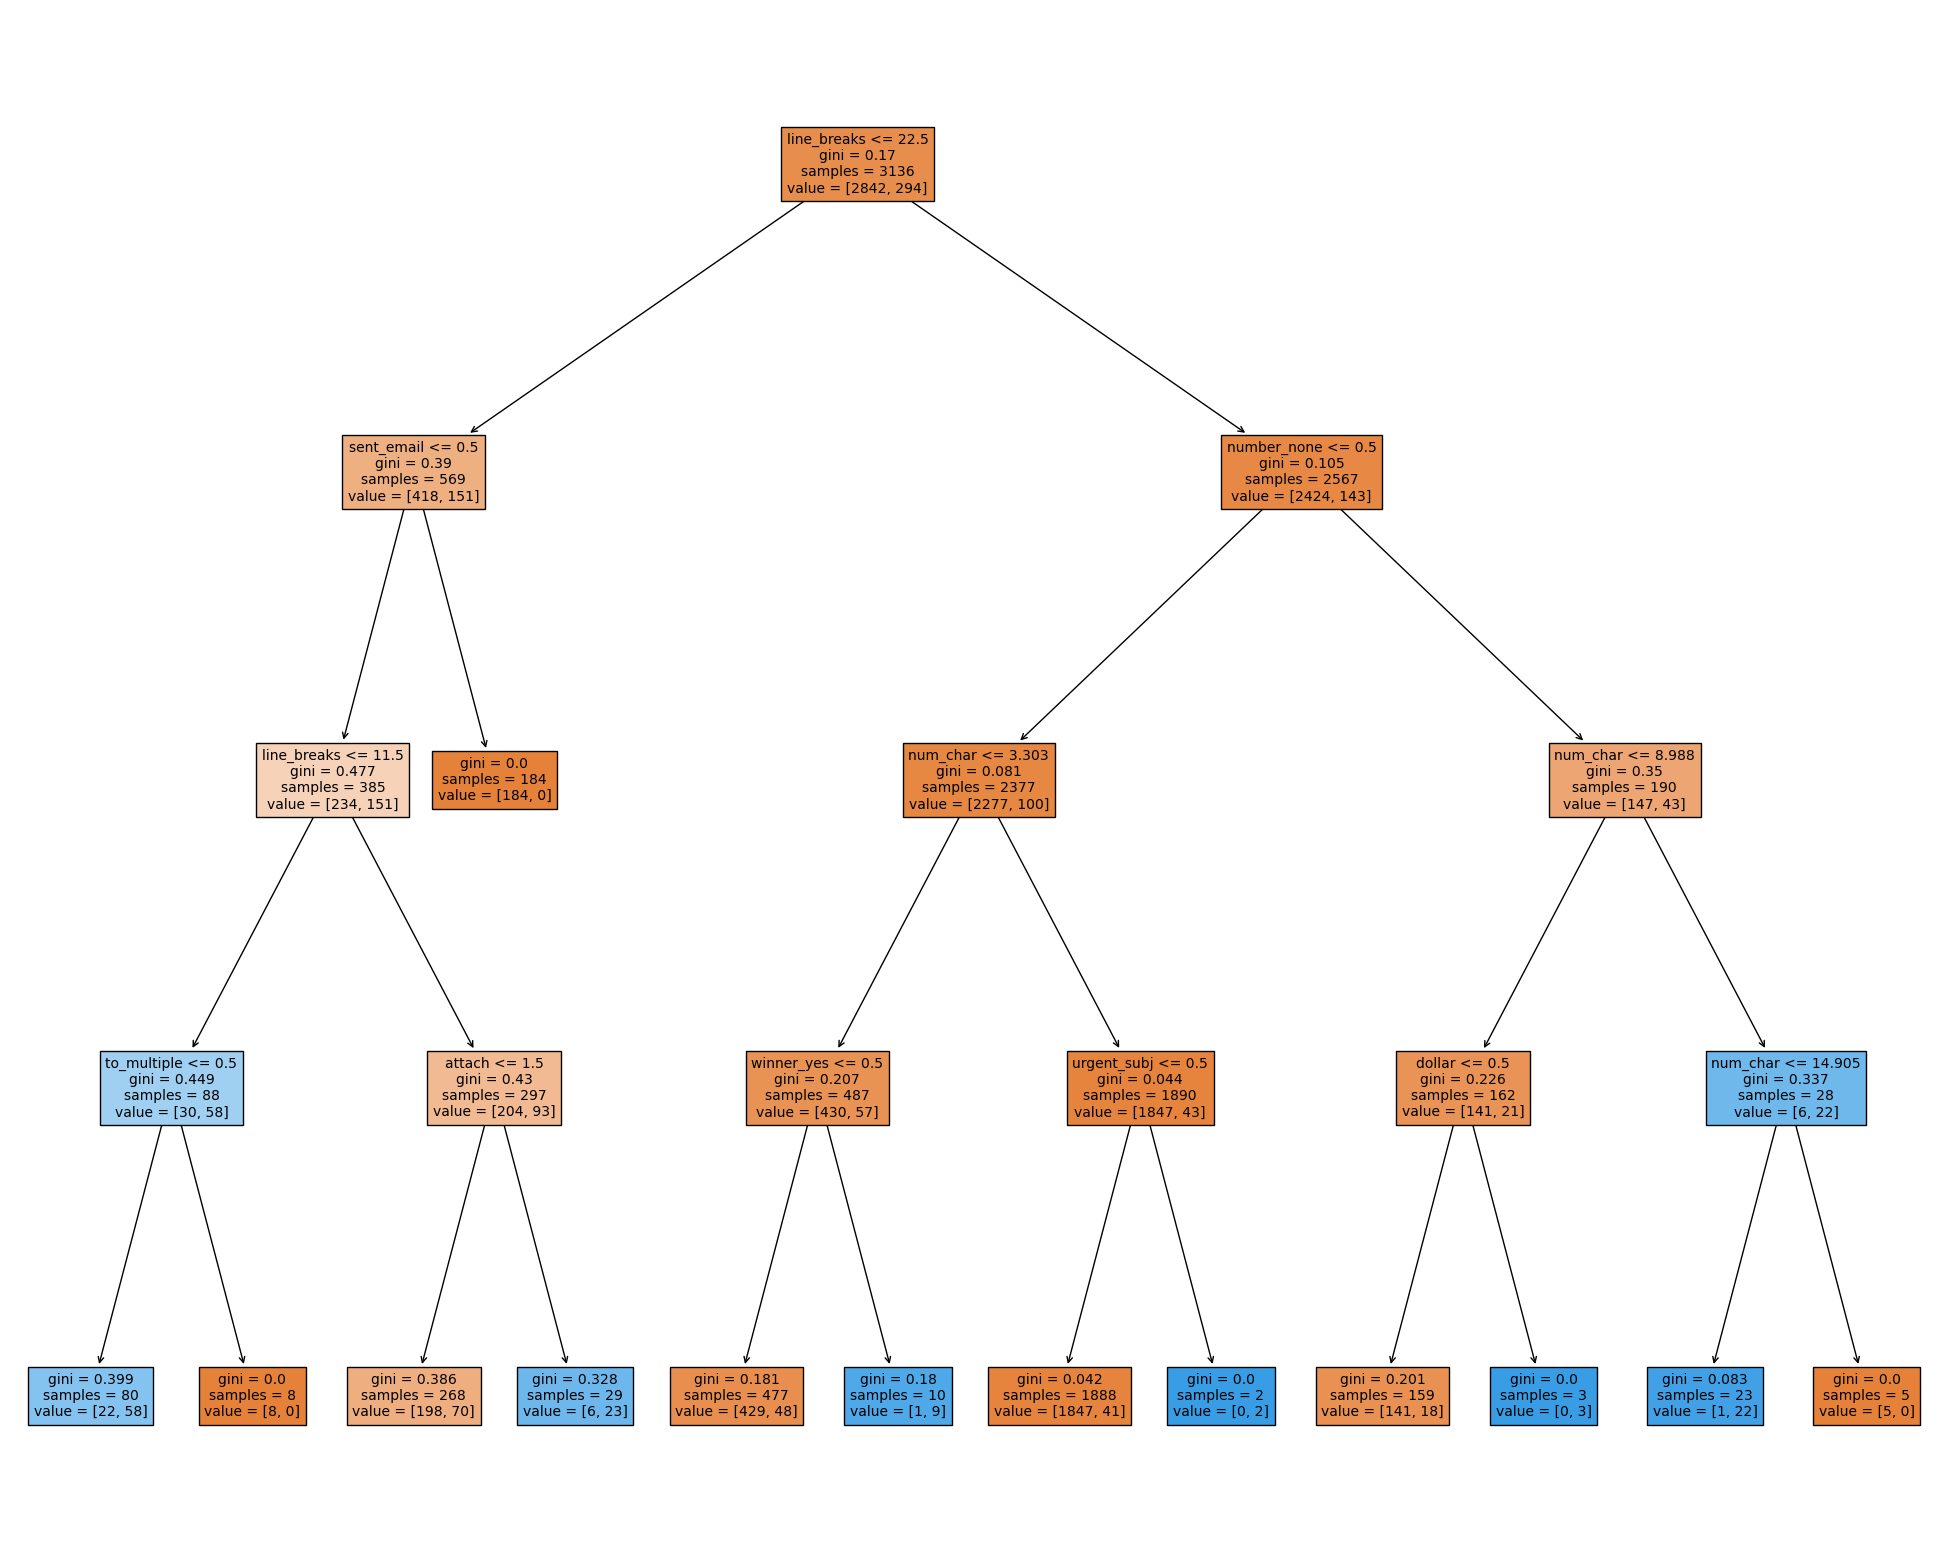

In [20]:
## Construcción del arbol
arbol=tree.DecisionTreeClassifier(criterion="gini", max_depth=4)
arbol.fit(X_train, y_train)
fig = plt.figure(figsize=(25,20))
_ = tree.plot_tree(arbol, feature_names=X_train.columns, filled=True)

In [21]:
y_pred=arbol.predict(X_test)
confusion_matrix(y_test, y_pred)


array([[704,   8],
       [ 52,  21]], dtype=int64)

In [22]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.93      0.99      0.96       712
           1       0.72      0.29      0.41        73

    accuracy                           0.92       785
   macro avg       0.83      0.64      0.69       785
weighted avg       0.91      0.92      0.91       785



In [23]:
### Validacion cruzada para obtener la profundidad optima
parameters = {'max_depth':range(2,20)} ### voy a probar desde 3 hasta 20
arbol= GridSearchCV(tree.DecisionTreeClassifier(), parameters,scoring="accuracy", n_jobs=-1) ## Metrica r2
arbol.fit(X=X_train, y=y_train)
tree_model = arbol.best_estimator_ ## El mejor modelo
print (arbol.best_score_, arbol.best_params_) 

0.9295299627180285 {'max_depth': 11}


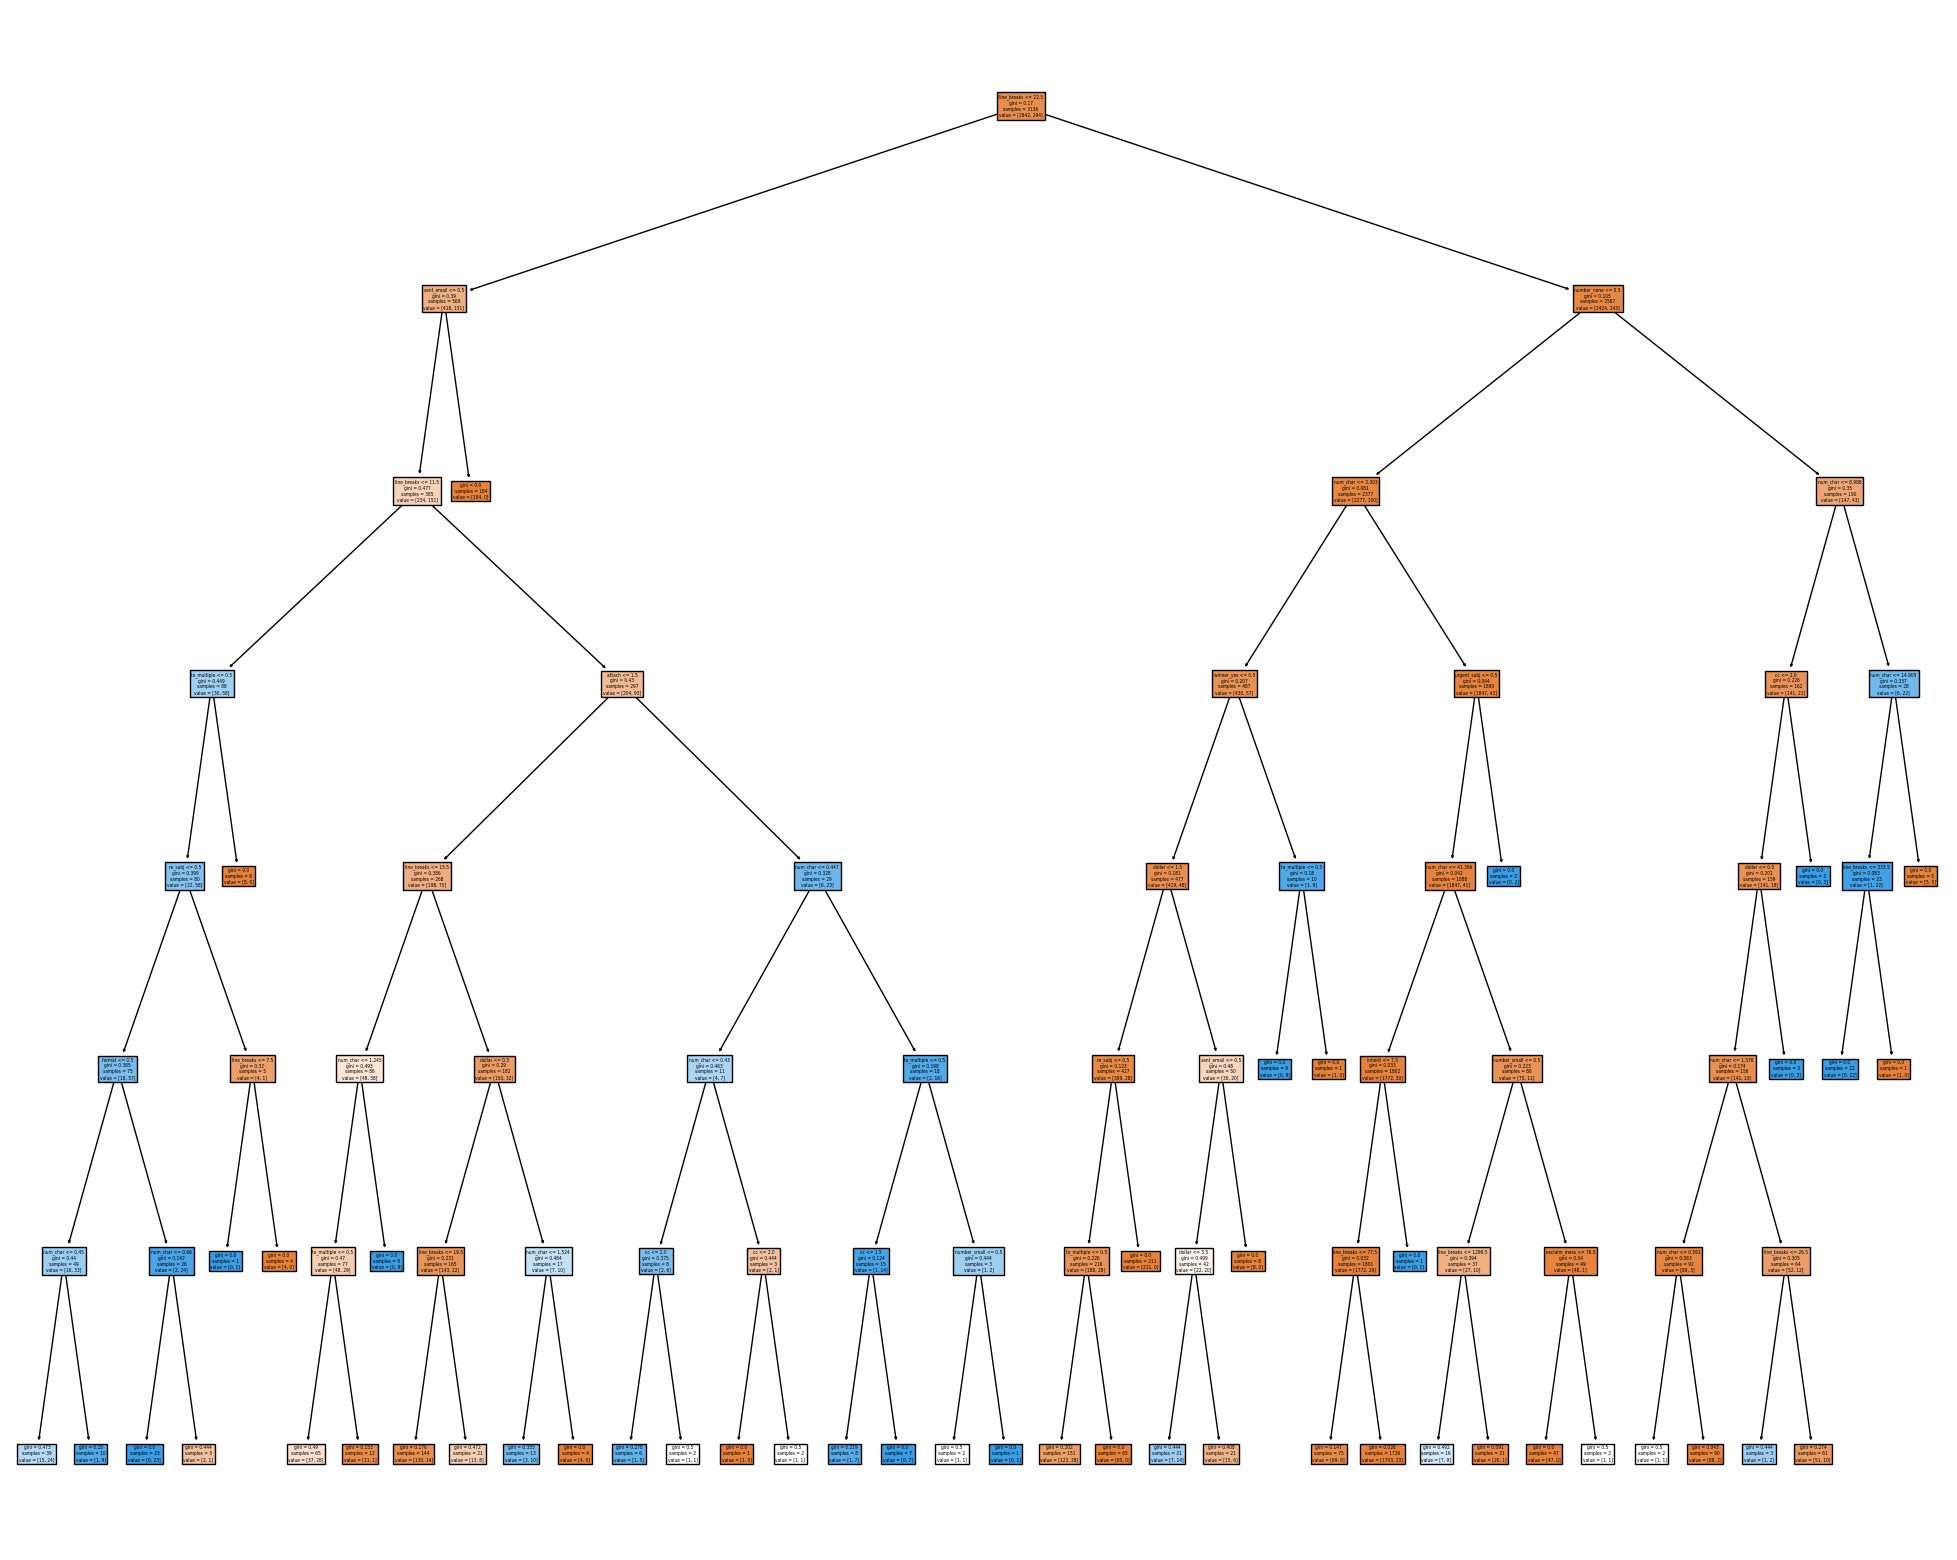

In [24]:
## Construcción del arbol
arbol=tree.DecisionTreeClassifier(criterion="gini", max_depth=7)
arbol.fit(X_train, y_train)
fig = plt.figure(figsize=(25,20))
_ = tree.plot_tree(arbol, feature_names=X_train.columns, filled=True)

In [25]:
y_pred=arbol.predict(X_test)
confusion_matrix(y_test, y_pred)

array([[697,  15],
       [ 43,  30]], dtype=int64)

## Problema
Como hay pocos datos de spam, entonces el modelo se ajusta muy mal a elegir un correo como Spam.

Dos soluciones:
1. Aumentar datos, lo cual es muy usado en imagenes
2. Reducir datos en la categoria más grande

# Tarea
Seleccione una muestra de 367 datos no Spam y unala a los 367 datos de spam y construya el árbol y evalue las métricas 

In [26]:
NoSpam=email[email["spam"]==0]
Spam=email[email["spam"]==1]
SampleNoS=NoSpam.sample(n=Spam.shape[0])
Base=pd.concat([Spam, SampleNoS])
Base.groupby("spam").size()

spam
0    367
1    367
dtype: int64

In [27]:
Y=Base["spam"].astype(str) ### Volver a Y cualitativa
X=Base.drop(["spam", "time"], axis=1)
X=pd.get_dummies(X, drop_first=True) 
X_train, X_test, y_train, y_test=train_test_split(X, Y, test_size=0.2, stratify=Y)

In [28]:
### Validacion cruzada para obtener la profundidad optima
parameters = {'max_depth':range(2,20)} ### voy a probar desde 3 hasta 20
arbol= GridSearchCV(tree.DecisionTreeClassifier(), parameters,scoring="accuracy", n_jobs=-1) ## Metrica r2
arbol.fit(X=X_train, y=y_train)
tree_model = arbol.best_estimator_ ## El mejor modelo
print (arbol.best_score_, arbol.best_params_) 

0.8057366362451107 {'max_depth': 13}


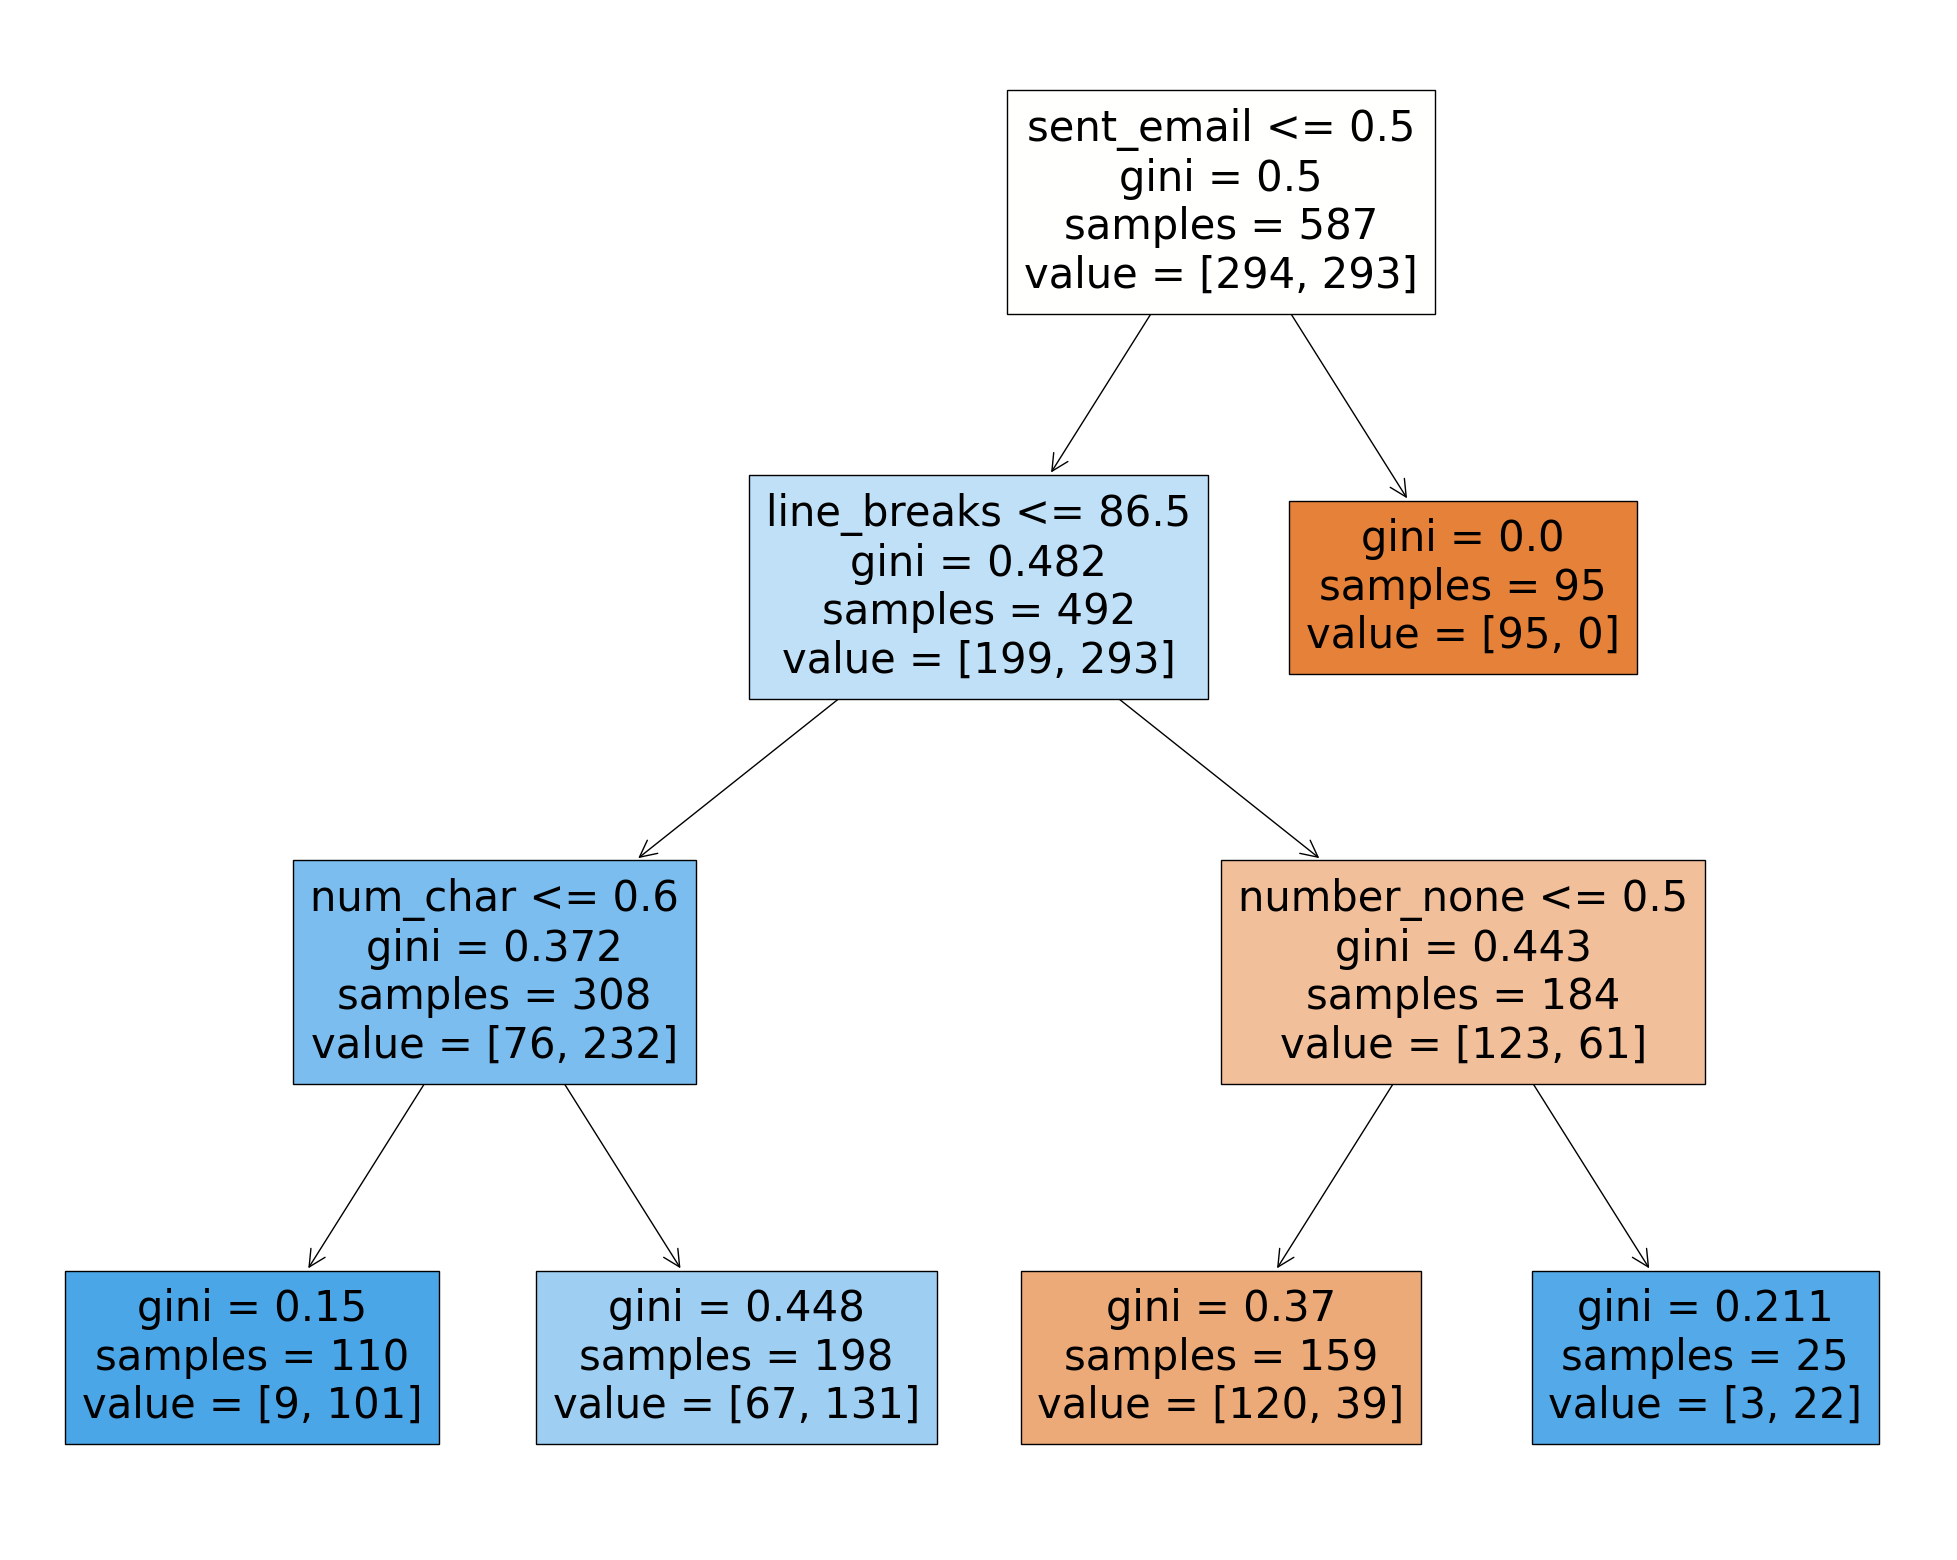

In [29]:
## Construcción del arbol
arbol=tree.DecisionTreeClassifier(criterion="gini", max_depth=3)
arbol.fit(X_train, y_train)
fig = plt.figure(figsize=(25,20))
_ = tree.plot_tree(arbol, feature_names=X_train.columns, filled=True)

In [30]:
from sklearn.metrics import classification_report
y_pred=arbol.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.86      0.82      0.84        73
           1       0.83      0.86      0.85        74

    accuracy                           0.84       147
   macro avg       0.84      0.84      0.84       147
weighted avg       0.84      0.84      0.84       147



# Tarea,
Encontrar el "mejor" arbol para clasificar la clase del vino

In [31]:
url="https://raw.githubusercontent.com/Cruzalirio/Ucentral/master/Bases/Vino.csv"
vino=pd.read_csv(url, sep=";", decimal=",")
vino

,Alcohol,Malic acid,Ash,Alcalinity of ash,Magnesium,Total phenols,Flavanoids,Nonflavanoid phenols,Proanthocyanins,Color intensity,Hue,OD280/OD315 of diluted wines,Proline,Class
0,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065,1
1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050,1
2,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185,1
3,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480,1
4,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
148,13.71,5.65,2.45,20.5,95,1.68,0.61,0.52,1.06,7.70,0.64,1.74,740,3
149,13.40,3.91,2.48,23.0,102,1.80,0.75,0.43,1.41,7.30,0.70,1.56,750,3
150,13.27,4.28,2.26,20.0,120,1.59,0.69,0.43,1.35,10.20,0.59,1.56,835,3
151,13.17,2.59,2.37,20.0,120,1.65,0.68,0.53,1.46,9.30,0.60,1.62,840,3


In [32]:
Y=vino["Class"]### Volver a Y cualitativa
X=vino.drop(["Class"], axis=1)
X=pd.get_dummies(X, drop_first=True) 
X_train, X_test, y_train, y_test=train_test_split(X, Y, test_size=0.2, stratify=Y)

In [33]:
### Validacion cruzada para obtener la profundidad optima
parameters = {'max_depth':range(2,20)} ### voy a probar desde 3 hasta 20
arbol= GridSearchCV(tree.DecisionTreeClassifier(), parameters,scoring="accuracy", n_jobs=-1) ## Metrica r2
arbol.fit(X=X_train, y=y_train)
tree_model = arbol.best_estimator_ ## El mejor modelo
print (arbol.best_score_, arbol.best_params_) 

0.8856666666666667 {'max_depth': 18}


Text(0.5, 1.0, 'Total Impurity vs effective alpha for training set')

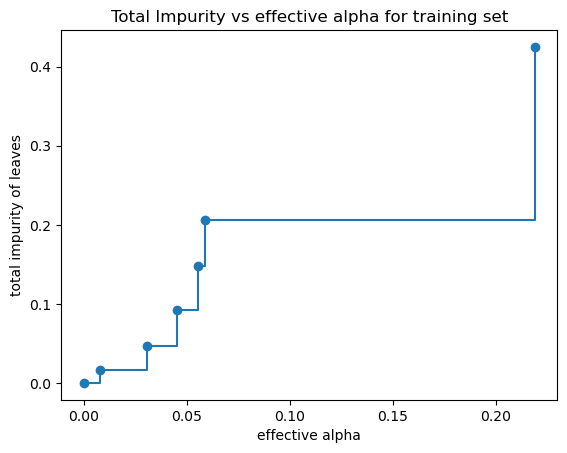

In [34]:
arbol = tree.DecisionTreeClassifier(random_state=0)
alpha= arbol.cost_complexity_pruning_path(X_train, y_train)
ccp_alphas, impurities = alpha.ccp_alphas, alpha.impurities
fig, ax = plt.subplots()
ax.plot(ccp_alphas[:-1], impurities[:-1], marker='o', drawstyle="steps-post")
ax.set_xlabel("effective alpha")
ax.set_ylabel("total impurity of leaves")
ax.set_title("Total Impurity vs effective alpha for training set")

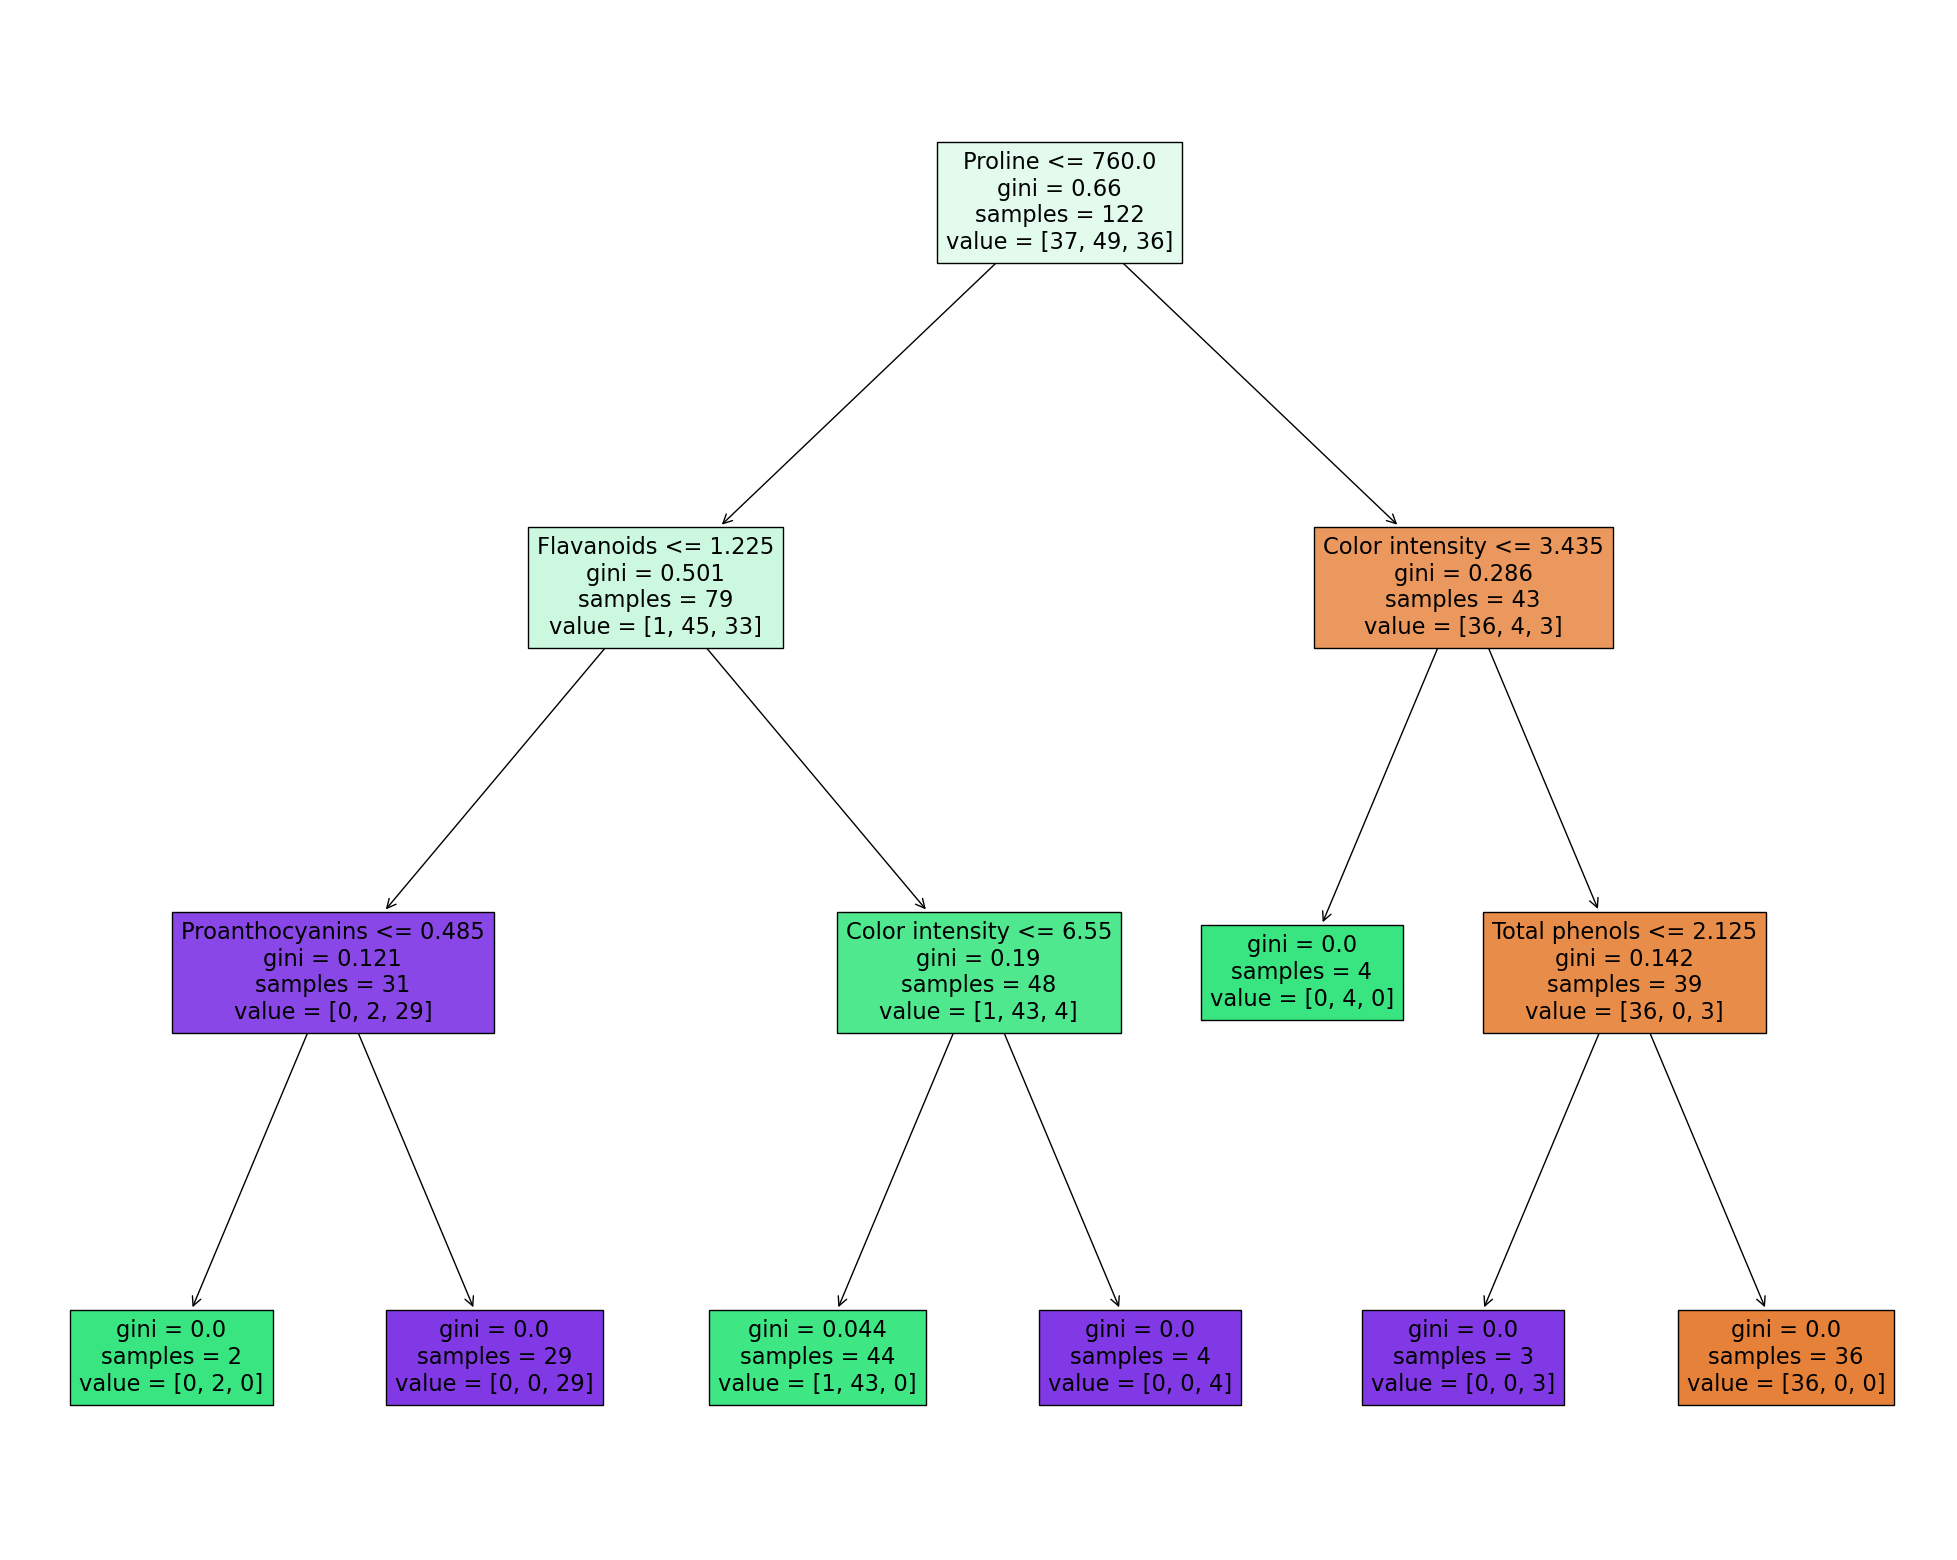

In [35]:
## Construcción del arbol
arbol=tree.DecisionTreeClassifier(criterion="gini", ccp_alpha=0.03)
arbol.fit(X_train, y_train)
fig = plt.figure(figsize=(25,20))
_ = tree.plot_tree(arbol, feature_names=X_train.columns, filled=True)

In [36]:
y_pred=arbol.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           1       1.00      1.00      1.00        10
           2       0.92      0.92      0.92        12
           3       0.89      0.89      0.89         9

    accuracy                           0.94        31
   macro avg       0.94      0.94      0.94        31
weighted avg       0.94      0.94      0.94        31



In [37]:
confusion_matrix(y_test, y_pred)

array([[10,  0,  0],
       [ 0, 11,  1],
       [ 0,  1,  8]], dtype=int64)

In [38]:
arbol.predict(X_test) ## Predice la clase 

array([2, 1, 1, 3, 3, 2, 2, 1, 1, 2, 1, 1, 1, 2, 1, 3, 2, 3, 3, 2, 1, 3,
       2, 3, 3, 3, 2, 2, 2, 1, 2], dtype=int64)

In [39]:
arbol.predict_proba(X_test) ## Predice la probabilidad de cada clase

array([[0.02272727, 0.97727273, 0.        ],
       [1.        , 0.        , 0.        ],
       [1.        , 0.        , 0.        ],
       [0.        , 0.        , 1.        ],
       [0.        , 0.        , 1.        ],
       [0.02272727, 0.97727273, 0.        ],
       [0.02272727, 0.97727273, 0.        ],
       [1.        , 0.        , 0.        ],
       [1.        , 0.        , 0.        ],
       [0.02272727, 0.97727273, 0.        ],
       [1.        , 0.        , 0.        ],
       [1.        , 0.        , 0.        ],
       [1.        , 0.        , 0.        ],
       [0.02272727, 0.97727273, 0.        ],
       [1.        , 0.        , 0.        ],
       [0.        , 0.        , 1.        ],
       [0.02272727, 0.97727273, 0.        ],
       [0.        , 0.        , 1.        ],
       [0.        , 0.        , 1.        ],
       [0.02272727, 0.97727273, 0.        ],
       [1.        , 0.        , 0.        ],
       [0.        , 0.        , 1.        ],
       [0.